In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [2]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BNB&tsym=USD&limit=500')
df = pd.DataFrame(json.loads(res.content)['Data'])
df = df.set_index('time')
df.index = pd.to_datetime(df.index, unit='s')
target_col='close'

In [3]:
df

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2021-09-08,425.38,382.92,418.26,195692.48,80242571.95,414.95,direct,
2021-09-09,436.19,403.77,414.95,187049.96,78137474.02,421.29,direct,
2021-09-10,439.39,393.80,421.29,207058.27,85154445.70,401.39,direct,
2021-09-11,415.11,399.67,401.39,126299.87,51490028.75,404.98,direct,
2021-09-12,421.67,397.80,404.98,112049.68,46254918.87,416.93,direct,
...,...,...,...,...,...,...,...,...
2023-01-17,305.32,295.65,298.87,35446.89,10661620.10,299.29,direct,
2023-01-18,304.69,281.70,299.29,77879.77,22881971.29,286.83,direct,
2023-01-19,295.13,286.28,286.83,26884.57,7810235.37,294.65,direct,


In [25]:
df = df.drop(['conversionType','conversionSymbol'], axis=1)
df

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2020-06-10,17.75,17.37,17.39,962446.29,1.678274e+07,17.44
2020-06-11,16.43,16.09,17.44,1079386.26,1.751077e+07,16.22
2020-06-12,16.89,16.51,16.22,1009410.77,1.676989e+07,16.61
2020-06-13,16.88,16.62,16.61,856213.51,1.441580e+07,16.84
2020-06-14,16.56,16.31,16.84,770141.79,1.274115e+07,16.54
...,...,...,...,...,...,...
2021-10-19,497.71,480.94,484.97,219051.01,1.069513e+08,488.03
2021-10-20,505.86,480.01,488.03,147082.49,7.265439e+07,501.47
2021-10-21,504.96,393.13,501.47,249685.76,1.207725e+08,471.13


In [26]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

In [27]:
def train_test_split(df, test_size=0.4):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [28]:
train, test = train_test_split(df,test_size=0.4)

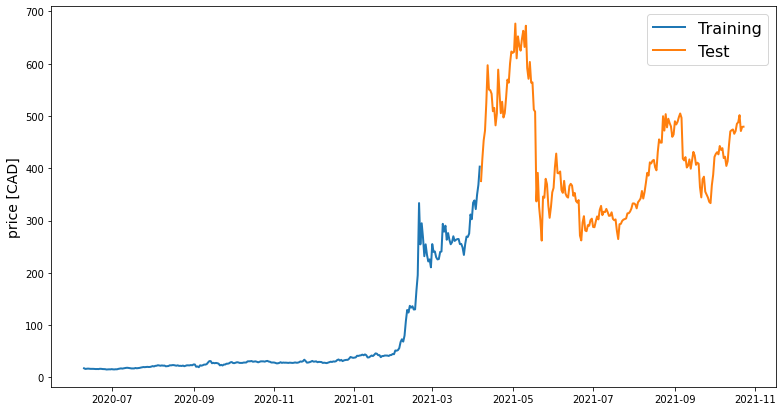

In [29]:
line_plot(train[target_col], test[target_col], 'Training', 'Test', title='')

In [30]:
print(train)
print(test)

              high     low    open  volumefrom      volumeto   close
time                                                                
2020-06-10   17.75   17.37   17.39   962446.29  1.678274e+07   17.44
2020-06-11   16.43   16.09   17.44  1079386.26  1.751077e+07   16.22
2020-06-12   16.89   16.51   16.22  1009410.77  1.676989e+07   16.61
2020-06-13   16.88   16.62   16.61   856213.51  1.441580e+07   16.84
2020-06-14   16.56   16.31   16.84   770141.79  1.274115e+07   16.54
...            ...     ...     ...         ...           ...     ...
2021-04-02  357.53  327.91  334.24  1086263.62  3.676057e+08  338.41
2021-04-03  336.06  314.77  338.41   644763.36  2.075512e+08  321.90
2021-04-04  353.62  325.80  321.90   660919.82  2.310242e+08  349.55
2021-04-05  383.63  348.98  349.55   907502.26  3.342466e+08  368.31
2021-04-06  411.70  358.68  368.31  1274785.99  5.138100e+08  403.06

[301 rows x 6 columns]
              high     low    open  volumefrom      volumeto   close
time      

In [31]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [32]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [33]:
def prepare_data(df, target_col, window_len=5, zero_base=True, test_size=0.4):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [62]:
def build_lstm_model(input_data, output_size, neurons=120, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [63]:
np.random.seed(42)
window_len = 5
test_size = 0.4
zero_base = True
lstm_neurons = 120
epochs = 40
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [64]:
train, test, X_train, X_test, y_train, y_test = prepare_data(df, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [69]:
#Early stopping using callbacks
#from keras.callbacks import EarlyStopping
#es = EarlyStopping(mode='min',verbose=1,patience=4)

In [67]:
model = build_lstm_model( X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit( X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, validation_data=(X_test,y_test), verbose=1, shuffle=True)

Epoch 1/40
9/9 [==============================] - 2s 60ms/step - loss: 0.0340 - val_loss: 0.0166
Epoch 2/40
9/9 [==============================] - 0s 10ms/step - loss: 0.0216 - val_loss: 0.0112
Epoch 3/40
9/9 [==============================] - 0s 9ms/step - loss: 0.0162 - val_loss: 0.0095
Epoch 4/40
9/9 [==============================] - 0s 10ms/step - loss: 0.0141 - val_loss: 0.0090
Epoch 5/40
9/9 [==============================] - 0s 10ms/step - loss: 0.0140 - val_loss: 0.0081
Epoch 6/40
9/9 [==============================] - 0s 9ms/step - loss: 0.0131 - val_loss: 0.0083
Epoch 7/40
9/9 [==============================] - 0s 9ms/step - loss: 0.0120 - val_loss: 0.0086
Epoch 8/40
9/9 [==============================] - 0s 10ms/step - loss: 0.0114 - val_loss: 0.0075
Epoch 9/40
9/9 [==============================] - 0s 9ms/step - loss: 0.0119 - val_loss: 0.0084
Epoch 10/40
9/9 [==============================] - 0s 10ms/step - loss: 0.0127 - val_loss: 0.0075
Epoch 11/40
9/9 [================

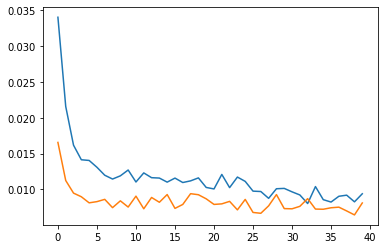

In [68]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [70]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.05285522335679238

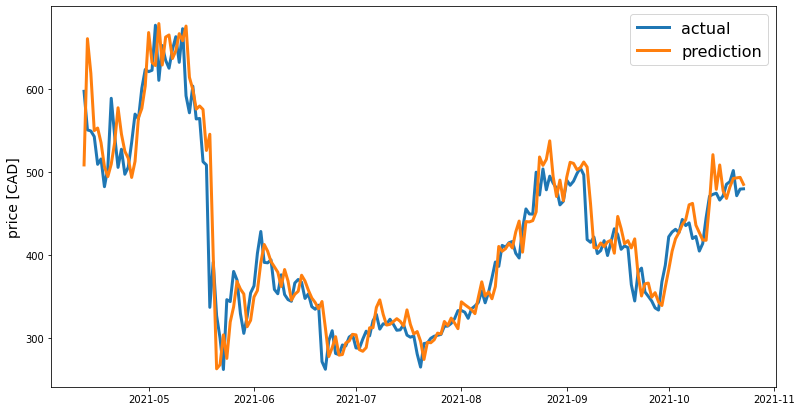

In [71]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [72]:
model.save('BNBmodel.hdf5')